# Time Variant Filter

This tutorial explains how to use MoSQITo to filter the harmonic frequencies generated by a rotating electromagnetic motor. Two .wav or .uff signals that contain a recording of the engine acceleration ramp and a tracking signal that provides the variation of RPMs will be needed. There are two ways to provide the signals to the filter: as paths to the file or as data already loaded.

## Load signals

An Audio object is first created by importing an audio file. In this example, the signal is imported from a .uff file. The tutorial Audio signal basic operations gives more information about the syntax of the import and the other supported file types. It also explains how to plot the time signal, compute and plot its 1/3 octave band spectrum, compute its overall level, etc.

### Load original signal from a .wav file


In [1]:
# Import load class
from mosqito.functions.shared.load import load

# Load the original signal
original_signal, fs = load(False,
    "C:/josema_rep/MoSQITo/mosqito/tests/variant_filter/signals/RUN5_RunUp_60s_Track1_Rec0.uff",
    calib=2 * 2 ** 0.5
)

# Load the tracking signal
tracking_signal, fs = load(False,
    "C:/josema_rep/MoSQITo/mosqito/tests/variant_filter/signals/RUN5_RunUp_60s_RPM-profile_Rec0.uff",
    calib=1
)

Signal resampled to 48 kHz to allow calculation.
Signal resampled to 48 kHz to allow calculation.


### Determine the filter parameters

In [2]:
#Filter parameters
harmonic_order = 1     #harmonics 1, 2, 3, ...
att = 6               #Attenuation in 3, 6, 9, 12 dB
filter_type = 'fir'    #Type of filter: 'fir' or 'iir'

### Apply the filter

In [3]:
from mosqito.functions.variant_filter.variant_filter import variant_filter

#Application of the variant filter
original_signal, fir_filtered_signal, Fs = variant_filter(
        original_signal, tracking_signal,filter_type, harmonic_order, att
)

### Save signals in .wav files
Saving both the original and the filtered signals in .wav files allows us to listen to them and appreciate the filtering carried out.

In [4]:
from scipy.io.wavfile import write
import numpy as np

#Scale both signals to integers to write a wav file
scale = np.max([np.max(np.abs(original_signal)), np.max(np.abs(fir_filtered_signal))])
scaled_o = np.int16(original_signal / scale * 32767)
scaled_fir = np.int16(fir_filtered_signal / scale * 32767)

write('motor_signal.wav', Fs, scaled_o)
write('FIR_filtered_motor_signal_'+str(harmonic_order)+' harmonic.wav', Fs, scaled_fir)

### Show the results
The results of the filtering will be displayed on a three-dimensional spectrogram where the axes correspond to time, frequency, and amplitude. For this, the specgram function of the Pylab library cluster will be used, including numpy, scipy, sympy, pandas, matplotlib, ipython. This will allow us to use python as if it were matlab. Data are split into NFFT length segments and the spectrum of each section is computed. The windowing function window is applied to each segment, and the amount of overlap of each segment is specified with noverlap.The spectrogram is plotted as a colormap.

The X axis will correspond to the time variable, the Y axis the frequency and the Z axis, corresponding to the color of the spectrogram, it will be the amplitude of the signal.

Additionally, the tracking signal will be shown below the spectrogram to be able to visualize the relationship between the increase in the speed of rotation with the evolution of the harmonics generated.

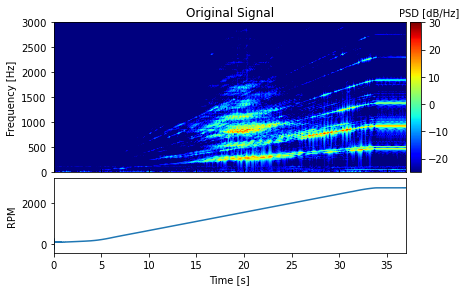

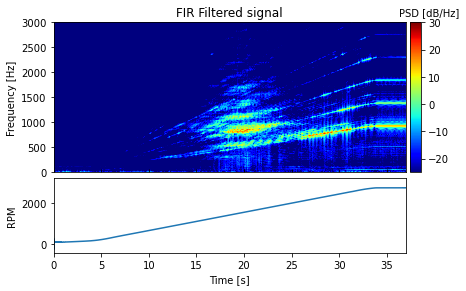

In [5]:
import pylab as plt
import matplotlib as mpl
from matplotlib import gridspec

#Time interval in seconds of the tracking signal
l_rpm=len(tracking_signal)
t_rpm = np.arange(0, l_rpm)/ fs 

#Set plot number of samples
NFFT = 4096
noverlap = NFFT / 2

#Set minimun shown value
vmin = 20*np.log10(np.max(original_signal)) - 70

#Set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

#Plot Spectrogram original signal
ax1 = plt.subplot(gs[0])
pxx,  freq, t, cax = plt.specgram(
    original_signal, 
    NFFT=NFFT,                                 
    Fs=Fs,
    vmin=vmin, 
    noverlap=noverlap,
    cmap = plt.cm.jet, 
    window=plt.window_none
)
plt.ylabel('Frequency [Hz]')
plt.title('Original Signal')
plt.axis([0,37,0,3000])
ax1.tick_params(axis='x', direction='in')

ax2 = plt.subplot(gs[1], sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.plot(t_rpm, tracking_signal)
plt.xlabel('Time [s]')
plt.ylabel('RPM')
plt.subplots_adjust(bottom=0.1, right=0.94, top=0.9, hspace=0.05)

norm = mpl.colors.Normalize(vmin=-25, vmax=30)
cax = plt.axes([0.95, 0.38, 0.025, 0.52])
plt.colorbar(
    mpl.cm.ScalarMappable(
        cmap = plt.cm.jet, 
        norm=norm
    ),
    cax=cax
).set_label('PSD [dB/Hz]', labelpad=-20, y=1.1, rotation=0)

plt.show()

#Plot Spectrogram filtered signal FIR
ax1 = plt.subplot(gs[0])
pxx,  freq, t, cax = plt.specgram(
    fir_filtered_signal, 
    NFFT=NFFT,
    Fs=Fs,
    vmin=vmin, 
    noverlap=noverlap,
    cmap = plt.cm.jet, 
    window=plt.window_none
)
plt.ylabel('Frequency [Hz]')
plt.title('FIR Filtered signal')
plt.axis([0,37 ,0,3000])
ax1.tick_params(axis='x', direction='in')

ax2 = plt.subplot(gs[1], sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.plot(t_rpm, tracking_signal)
plt.xlabel('Time [s]')
plt.ylabel('RPM')

plt.subplots_adjust(bottom=0.1, right=0.94, top=0.9, hspace=0.05)

cax = plt.axes([0.95, 0.38, 0.025, 0.52])
plt.colorbar(
    mpl.cm.ScalarMappable(
        cmap = plt.cm.jet, 
        norm=norm
    ),
    cax=cax
).set_label('PSD [dB/Hz]', labelpad=-20, y=1.1, rotation=0)

plt.show()